In [ ]:
import sys
print(sys.version)

In [ ]:
#
# Load and extract the 327k bucket names downloaded from Grayhat Warfare
#
# The provided S3 names contain complete AWS domain information as well, which will be one of the following formats:
# 1) [bucket_name].s3.amazonaws.com
# 2) [bucket_name].s3-[aws_region].amazonaws.com
# 3) [bucket_name].s3.[aws_region].amazonaws.com
# 
#
import json, re

def extract_bucket_name(bucket_url):
    # Define regex pattern to match and capture the bucket name
    pattern = r"^(.+)?\.s3(?:[\.-])(.+)?amazonaws.com(?:\.[a-z]{2})?$"
    
    # Search for the pattern in the given URL
    match = re.match(pattern, bucket_url)
    
    # Return the bucket name if found, otherwise None
    return match.group(1) if match else None


with open('buckets.json', 'r') as f:
    gh_data = json.load(f)

bucket_names = [x['bucket'] for x in gh_data]
bucket_names = [extract_bucket_name(x) for x in bucket_names]
bucket_names = [b for b in bucket_names if b is not None]

# Save point, all bucket names minus the AWS domains
with open('parsed_buckets.json', 'w') as f:
    json.dump(bucket_names, f, indent=2)

In [ ]:
#
# Modifying and (hopefully) simplifying our pipeline with Spacy.  We still need to tokenize as usual, let's 
# do that now.
#
import json

with open('parsed_buckets.json') as f:
    buckets = json.load(f)

# Start with a simple Regex based tokenizer for the light work.
custom_tokenizer = RegexpTokenizer(r'\d+|[a-zA-Z]+')
tokenized_buckets = []
for b in buckets:
   tokenized_buckets.append(custom_tokenizer.tokenize(b.lower()))

from wordsegment import load, segment
load()
results = []
for bucket in tokenized_buckets:
    current_tokens = []
    for b in bucket:
       current_tokens.extend(segment(b))
    results.append(current_tokens)

with open("tokenized_buckets.json", "w") as f:
    json.dump(results, f, indent=2)


In [ ]:
#
# 
# Set up the Spacy pipeline
#
import spacy
from spacy.tokens import Token, Span
from spacy.language import Language

# Load the spaCy pipeline
nlp = spacy.load("en_core_web_md")

# Add custom attributes
Token.set_extension("is_custom_tagged", default=False, force=True)
Token.set_extension("custom_tag", default=None, force=True)

# Define a custom tagging component
@Language.component("custom_tagger")
def custom_tagger(doc):
    custom_tags = {}
    with open('custom_tags.json', 'r') as f:
        custom_tag_src = json.load(f)
        for tag, words in custom_tag_src.items():
            for word in words:
                custom_tags[word] = tag

    for token in doc:
        if token.text in custom_tags:
            t = custom_tags[token.text]
            # print(f"Tagging {token.text} as {t}")
            token._.is_custom_tagged = True
            token._.custom_tag = t
            token.ent_type_ = t
            token.tag_ = t
    return doc

# Add the custom tagger to the pipeline
nlp.add_pipe("custom_tagger", after="ner")
# nlp.remove_pipe("tagger")
print("Pipeline Component Order:", nlp.pipe_names)

bucket_names = []
with open('tokenized_buckets.json', 'r') as f:
    tokenized_buckets = json.load(f)
    bucket_names.extend([" ".join(b) for b in tokenized_buckets])

with open('tagged_buckets.json', 'w') as f:
    all_tags = []
    for bucket_name in bucket_names:
        doc = nlp(bucket_name)
        # print("Token Details:")
        tags = []
        for token in doc:
            txt = token.lemma_
            tag = token.tag_ if token.ent_type_ == "" else token.ent_type_
            tags.append((txt, tag))
        all_tags.append(tags)

    json.dump(all_tags, f, indent=2)

In [ ]:
#
# Let's get some statistics on the n-gram tokens
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

n_grams = {}

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

for bucket_tags in tagged_buckets:
    tag_len = len(bucket_tags)
    count = n_grams.get(tag_len, 0)
    count = count + 1
    n_grams[tag_len] = count


#
# To prevent the long-tail from clogging up our view, filter out any n-grams with
# less than 50 count (out of 327,000)
#
filtered_n_grams = {key: value for key, value in n_grams.items() if value >= 50}

# Convert dictionary to DataFrame
df = pd.DataFrame(list(filtered_n_grams.items()), columns=["Key", "Value"])

# Sort the DataFrame by "Key" to match ascending key order
df = df.sort_values(by="Key")


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to normalize all values in the DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Plot the frequency with Seaborn
sns.set_style("dark")
sns.barplot(x="Key", y="Value", data=df)
plt.title("Frequency of n-gram bucket names")
plt.xlabel("n-gram")
plt.ylabel("frequency")
plt.show()




In [36]:
import json

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

#
# Given a list of tokenized and tagged buckets, return a map of transition counts between
# the tag types
#
# Keys are compund and of the form '<src>/<dst>'
#
def build_transition_counts(buckets) -> dict:
    transition_counts = {}

    ignored = 0
    for bucket in buckets:
        blen = len(bucket)
        counts_map = transition_counts.get(blen, {})
        if blen == 1:
            ignored = ignored +1
            continue # We can't operate on a unigram bucket name
        # Each bucket is a list(list(txt, tag)) , We only care about the tag and the following tag.
        src_tag = None
        for pair in bucket:
            tag = pair[1]
            if src_tag == None:
                # This is our first time through, save the tag and continue
                src_tag = tag
                continue
            else:
                # Mark the transition
                key = f"{src_tag}/{tag}"
                count = counts_map.get(key, 0)
                count = count + 1
                counts_map[key] = count
                src_tag = tag
        transition_counts[blen] = counts_map
    print(f"Ignored {ignored} unigram buckets")
    return transition_counts

counts = build_transition_counts(tagged_buckets)
for key, transition_map in counts.items():
    sorted_counts = {key: value for key, value in sorted(transition_map.items(), key=lambda item: item[1], reverse=True)}
    print(f"[{key}]: {sorted_counts}")


Ignored 5315 unigram buckets
[2]: {'NN/NN': 9254, 'PERSON/PERSON': 8495, 'NN/NNS': 4830, 'NNP/NNP': 3933, 'NNP/NN': 3769, 'ORG/ORG': 3545, 'JJ/NN': 3418, 'NNP/INFRA': 3057, 'NN/INFRA': 2408, 'PERSON/INFRA': 2003, 'NNP/NNS': 1996, 'ORG/INFRA': 1772, 'JJ/NNS': 1745, 'VB/NN': 1662, 'ORG/NN': 1302, 'INFRA/NN': 1209, 'ORG/NNP': 1200, 'ORG/NNS': 1165, 'NN/CARDINAL': 1150, 'NNP/CARDINAL': 862, 'JJ/INFRA': 837, 'NN/VBZ': 804, 'NN/WEB': 711, 'NNS/NN': 632, 'VB/INFRA': 622, 'NNP/WEB': 618, 'NNP/VBZ': 598, 'VB/NNS': 592, 'WEB/NN': 572, 'NNP/ORG': 562, 'NNS/VBP': 560, 'PERSON/NNP': 552, 'NNS/INFRA': 539, 'ORG/WEB': 514, 'DT/NN': 463, 'NNP/PERSON': 452, 'INFRA/PERSON': 446, 'GPE/NNP': 431, 'ORG/VBZ': 428, 'NNS/NNS': 417, 'INFRA/NNS': 402, 'NNP/PHASE': 386, 'IN/NN': 381, 'VBG/NN': 368, 'PERSON/NNS': 366, 'NNP/GPE': 364, 'CARDINAL/NN': 363, 'ORG/PHASE': 346, 'NN/VBP': 337, 'PHASE/NN': 323, 'NN/NNP': 323, 'NN/PHASE': 321, 'VB/PRP': 288, 'VBZ/NN': 282, 'VB/JJ': 278, 'NN/JJ': 278, 'INFRA/CARDINAL': 276,

In [ ]:
#
# Let's figure out how many unique tags we have here
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


with open('tagged_buckets.json', 'r') as f:
    tagged_buckets = json.load(f)

# Map n-gram -> map<tag, count>
tag_map = {}

for bucket in tagged_buckets:
    ngram = len(bucket)
    tags = tag_map.get(ngram, {})

    for tag_tuple in bucket:
        tuple_name = tag_tuple[1]
        count = tags.get(tuple_name, 0)
        count += 1
        tags[tuple_name] = count
    tag_map[ngram] = tags

# We'll save our tag collection here for the next stage
tag_export = {}

for ngram, tag_counts in tag_map.items():
    top_tags = sorted(tag_counts.items(), key=lambda item: item[1], reverse=True)[:20]

    tag_export[ngram] = top_tags

    df = pd.DataFrame(top_tags, columns=['Key', 'Value'])
    df['Scaled'] = df['Value'] / df['Value'].sum()

    # Sort the DataFrame by "Key" to match ascending key order
    # df = df.sort_values(by="Value")

    # Plot the frequency with Seaborn
    sns.set_style("dark")
    sns.barplot(x="Key", y="Scaled", data=df)
    plt.title(f"Tag Frequency for {ngram}-gram buckets (n={df['Value'].sum()})")
    plt.xlabel("Tag")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()

with open('ngram_tag_counts.json', 'w') as f:
    json.dump(tag_export, f, indent=2)

Ignored 5315 unigram buckets


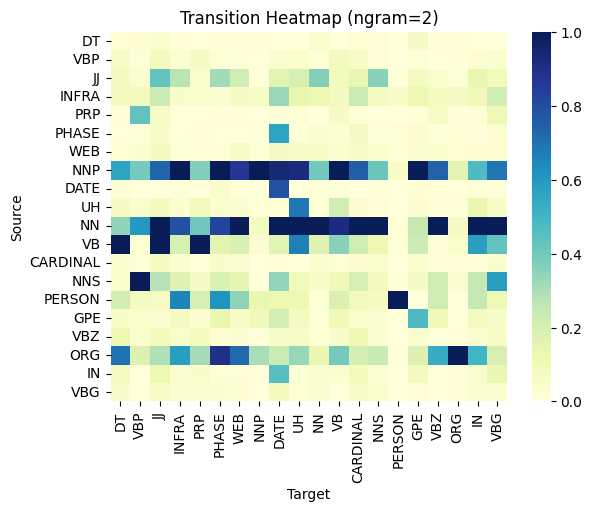

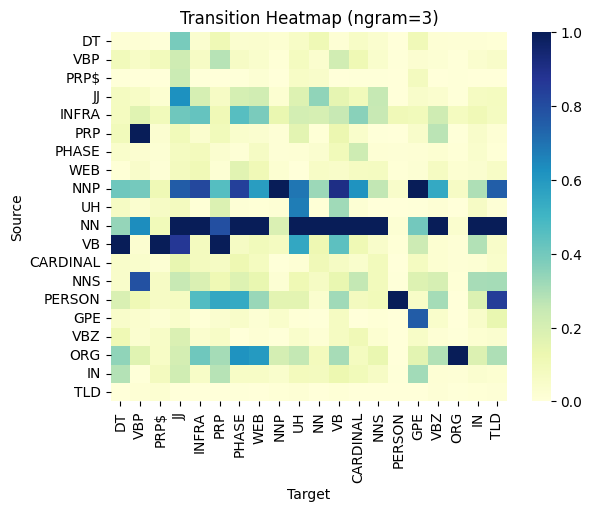

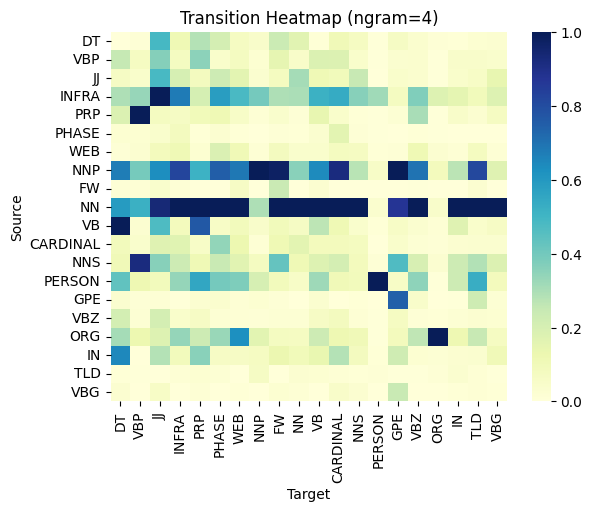

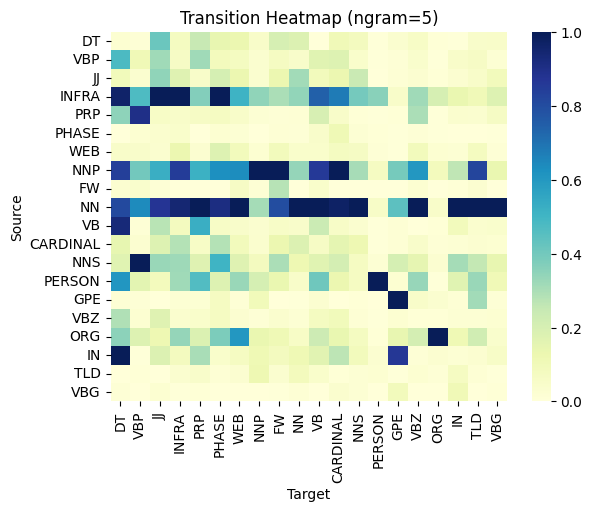

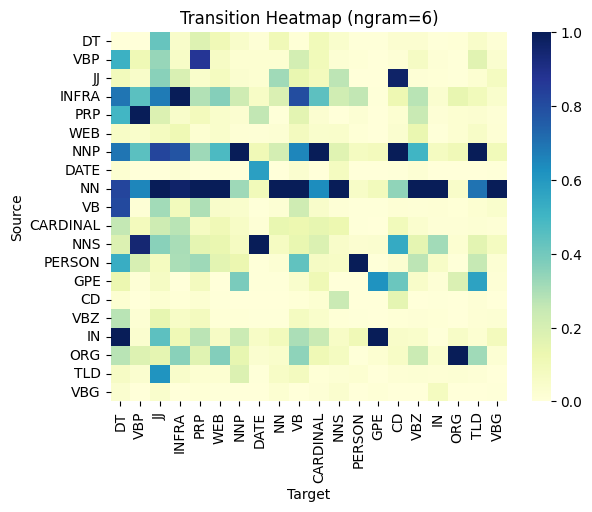

In [ ]:
#
# Build the heatmap of transitions for the top tags 
# for {2-6}-gram buckets
#
import json
import pandas as pd
import numpy as np

with open('ngram_tag_counts.json', 'r') as f:
    ngram_tag_counts = json.load(f)

with open('tagged_buckets.json', 'r') as f:
    tagged_buckets = json.load(f)

#
# Given a list of tokenized and tagged buckets, return a map of transition counts between
# the tag types
#
# Keys are compund and of the form '<src>/<dst>'
#
def build_transition_counts(buckets) -> dict:
    transition_counts = {}

    ignored = 0
    for bucket in buckets:
        blen = len(bucket)
        counts_map = transition_counts.get(blen, {})
        if blen == 1:
            ignored = ignored +1
            continue # We can't operate on a unigram bucket name
        # Each bucket is a list(list(txt, tag)) , We only care about the tag and the following tag.
        src_tag = None
        for pair in bucket:
            tag = pair[1]
            if src_tag == None:
                # This is our first time through, save the tag and continue
                src_tag = tag
                continue
            else:
                # Mark the transition
                key = f"{src_tag}/{tag}"
                count = counts_map.get(key, 0)
                count = count + 1
                counts_map[key] = count
                src_tag = tag
        transition_counts[blen] = counts_map
    print(f"Ignored {ignored} unigram buckets")
    return transition_counts

counts = build_transition_counts(tagged_buckets)

#
# At this point the transition counts are far too many to show in a heat map.  Filter this with
# the top tags. Filter our any transition that uses a tag not in the top list.  This is specific to the n-gram size.
#
frames = {}
for ngram, tags in counts.items():
    top_tags = set(k for k,_ in ngram_tag_counts[str(ngram)])
    size = min(20, len(top_tags))
    df = pd.DataFrame(np.zeros((size, size)), columns=list(top_tags), index=list(top_tags))
    for tag_pair in tags.items():
        (tag1, tag2) = tag_pair[0].split("/")
        if set(tag_pair[0].split("/")).issubset(top_tags):
            df.at[tag1, tag2] = tag_pair[1] 
    # print(df)
    frames[ngram] = df

import seaborn as sns
import matplotlib.pyplot as plt

for ngram in range(2,7):
    df = frames[ngram]
    normalized_df = (df - df.min()) / (df.max() - df.min())
    sns.heatmap(normalized_df, annot=False, cmap="YlGnBu")

    # Add labels and title
    plt.title(f"Transition Heatmap (ngram={ngram})")
    plt.xlabel("Target")
    plt.ylabel("Source")

    # Show the heatmap
    plt.show()

{2: {'PHASE': 922, 'NNS': 3567, 'PRP': 621, 'NN': 22769, 'ORG': 11806, 'INFRA': 3609, 'NNP': 19027, 'POS': 39, 'RB': 529, 'IN': 1119, 'VBN': 606, 'NNPS': 93, 'UH': 991, 'TLD': 200, 'VB': 5304, 'DEV': 303, 'WEB': 1445, 'PERSON': 13132, 'VBZ': 1123, 'VBP': 683, 'LS': 467, 'JJ': 7123, 'DT': 834, 'CARDINAL': 1026, 'VBG': 997, 'JJS': 100, 'DATE': 532, 'FW': 583, 'CD': 247, 'XX': 336, 'TIME': 47, 'QUANTITY': 35, 'PRODUCT': 248, 'LOC': 60, 'PRP$': 462, 'NORP': 468, 'NFP': 83, 'GPE': 1815, 'VBD': 533, 'MD': 106, 'RP': 50, 'LAW': 40, 'WDT': 9, 'CC': 80, 'JJR': 116, 'TO': 58, 'FAC': 56, '``': 11, 'RBR': 10, 'SYM': 4, 'WP': 14, 'ORDINAL': 45, 'WRB': 21, 'LANGUAGE': 8, 'RBS': 2, 'WORK_OF_ART': 19, 'PERCENT': 1, 'ADD': 25, 'MONEY': 5, 'EVENT': 9, ',': 2, 'AFX': 5, 'EX': 2, '-LRB-': 1, '.': 1}, 3: {'JJ': 7237, 'INFRA': 7141, 'POS': 307, 'VBN': 442, 'NNP': 17371, 'NN': 18698, 'TLD': 376, 'CARDINAL': 1433, 'VBP': 1117, 'TO': 115, 'PHASE': 1766, 'TIME': 45, 'VB': 6788, 'XX': 694, 'NNS': 2754, 'PERSON':

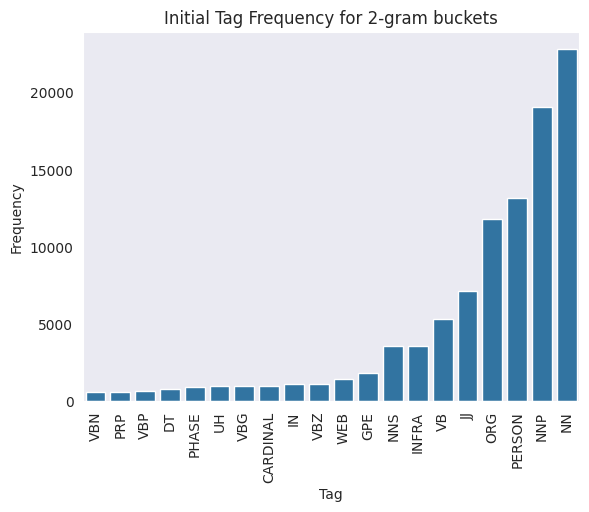

         Key  Value
19       VBG    856
18       VBZ    977
17       VBP   1117
16       GPE   1250
15        UH   1397
14  CARDINAL   1433
13       PRP   1485
12      PRP$   1493
11        IN   1729
10     PHASE   1766
9        WEB   1817
8         DT   2113
7        NNS   2754
6         VB   6788
5      INFRA   7141
4         JJ   7237
3        ORG  12258
2     PERSON  12613
1        NNP  17371
0         NN  18698


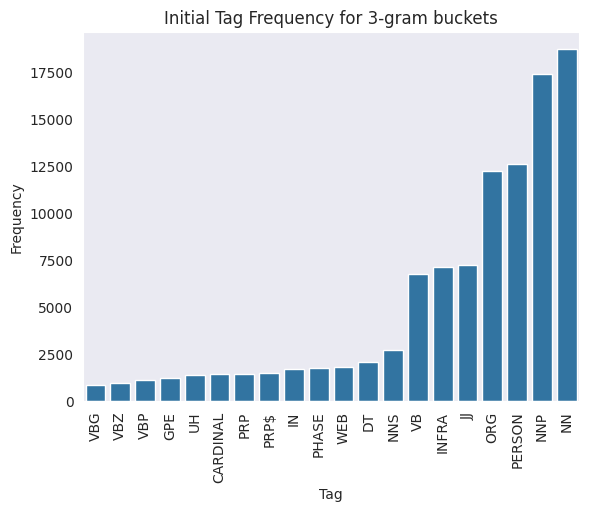

         Key  Value
18        UH     11
19        CD     11
17       VBP     15
16      NORP     31
15        FW     50
14       VBD     55
13       VBN     60
12       VBG     69
11        RB     71
10  CARDINAL     81
9        VBZ     91
8       DATE    102
7         JJ    184
6        GPE    236
5         VB    311
4        NNS    451
3        NNP    519
2     PERSON    802
1        ORG    856
0         NN   1258


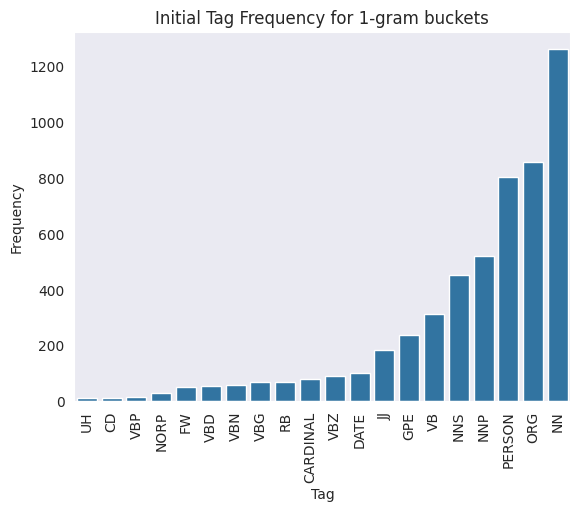

         Key  Value
19       GPE    206
18        UH    230
17       POS    246
16       DEV    272
15        IN    273
14  CARDINAL    297
13       PRP    311
12       VBG    338
11     PHASE    342
10       VBZ    374
9        WEB    392
8         DT    415
7         VB   1057
6         JJ   1134
5        NNS   1475
4     PERSON   1695
3        ORG   2086
2        NNP   2546
1         NN   4362
0      INFRA   7115


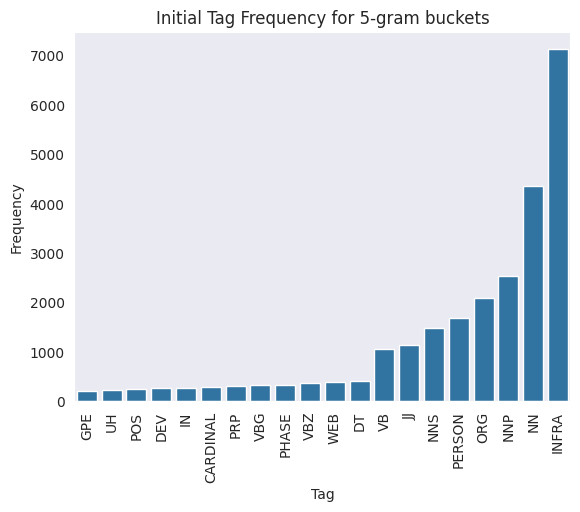

         Key  Value
19       VBP    491
18       VBG    513
17       GPE    547
16        UH    624
15      PRP$    670
14       VBZ    687
13     PHASE    691
12  CARDINAL    699
11       WEB    726
10        IN    789
9        PRP    885
8         DT   1333
7        NNS   2438
6         JJ   2575
5         VB   2826
4        ORG   4811
3     PERSON   4913
2        NNP   6480
1         NN   8317
0      INFRA  11075


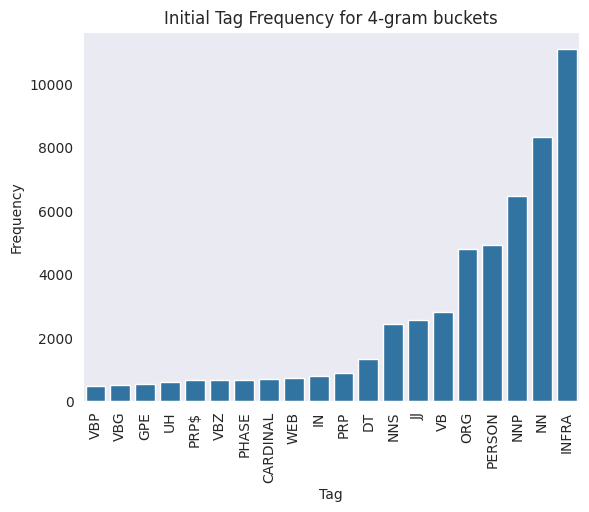

         Key  Value
19       VBZ    118
18       DEV    121
16     PHASE    128
17      NORP    128
15        IN    133
14       POS    134
13        DT    144
12  CARDINAL    147
11       WEB    154
10       PRP    176
9        VBG    225
8         VB    457
7        VBP    491
6        NNS    517
5     PERSON    674
4        ORG   1048
3        NNP   1212
2         JJ   1221
1      INFRA   2463
0         NN   4174


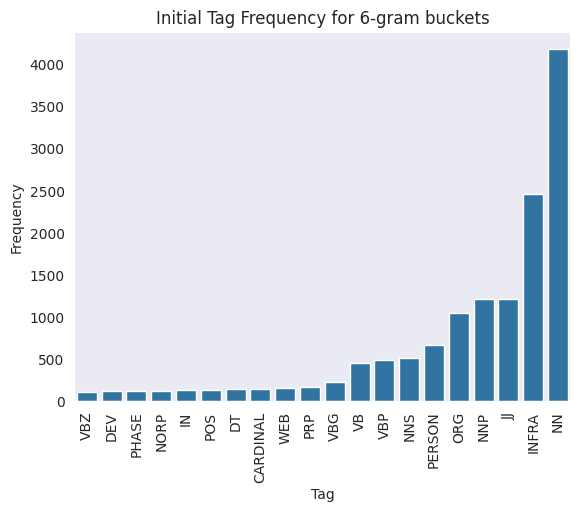

         Key  Value
19       GPE     18
18        LS     19
17        XX     20
16       VBG     21
15       PRP     23
14        UH     24
13       TLD     27
12       POS     30
11       WEB     37
10        DT     41
9   CARDINAL     44
8        NNS     48
7         IN     51
6         VB     67
5     PERSON    112
4        ORG    170
3         JJ    212
2        NNP    224
1      INFRA    283
0         NN    409


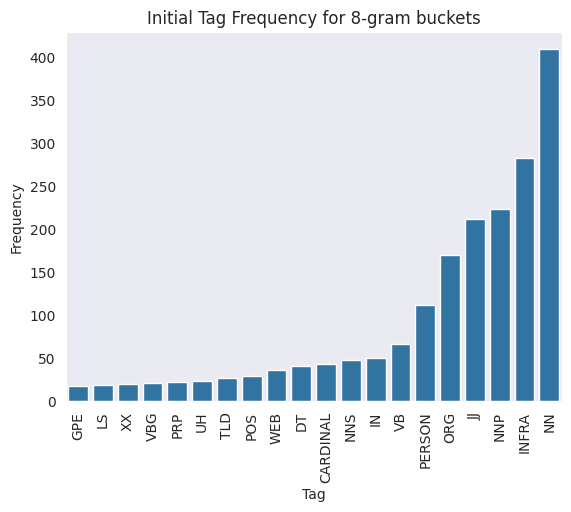

         Key  Value
19       DEV     43
18     PHASE     44
17       GPE     45
16       POS     53
15        UH     55
14       PRP     56
13        DT     57
12      NORP     60
11        LS     67
10       WEB     67
9        VBG     70
8   CARDINAL     92
7        NNS    180
6         VB    204
5     PERSON    323
4        ORG    431
3        NNP    548
2         JJ    786
1      INFRA    788
0         NN   1823


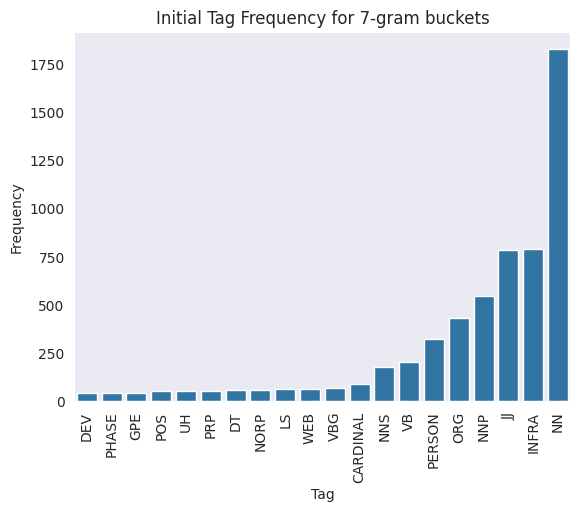

         Key  Value
19       VBZ      8
17       TLD      9
18        UH      9
15     PHASE     10
16       VBP     10
13       PRP     12
14       WEB     12
12        DT     14
11        LS     16
10  CARDINAL     16
9         IN     18
8        POS     19
7         VB     20
6        NNS     23
5         JJ     47
4     PERSON     48
3        ORG     72
2      INFRA     92
1        NNP    104
0         NN    107


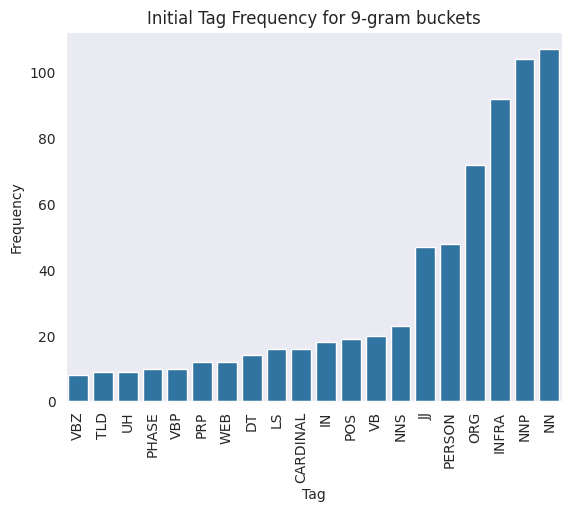

         Key  Value
18        LS      3
19        IN      3
15        FW      4
17        DT      4
16       GPE      4
14        MD      6
13       WEB      7
11        XX      7
12       VBP      7
9        POS      8
10       PRP      8
8        NNS     10
7         JJ     12
6         VB     13
5     PERSON     15
4   CARDINAL     19
3        ORG     30
2        NNP     32
1      INFRA     34
0         NN     43


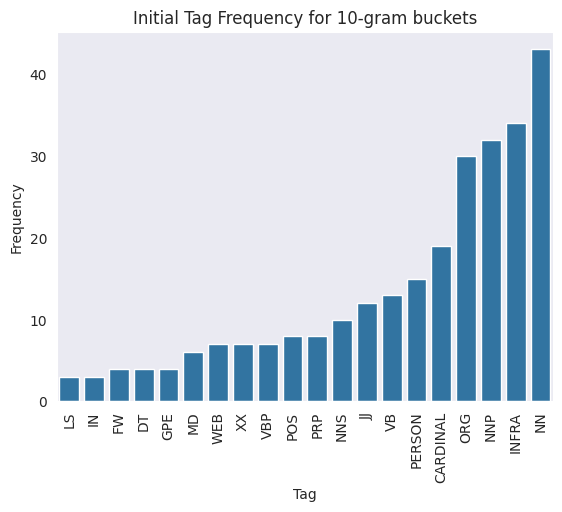

         Key  Value
12        IN      1
13       POS      1
14       GPE      1
15       VBD      1
11       TLD      1
18        VB      1
17      DATE      1
16        DT      1
10        XX      2
9   CARDINAL      2
8         LS      3
7         JJ      3
6        VBP      4
5        NNP      4
3      INFRA      4
4        NNS      4
2     PERSON     11
1        ORG     12
0         NN     23


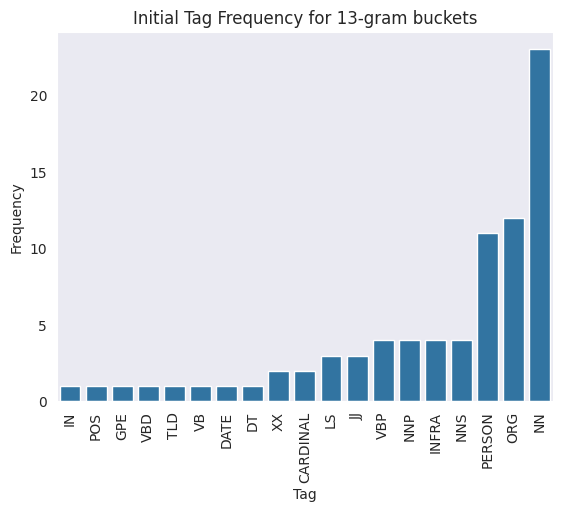

       Key  Value
7      NNS      1
10    PRP$      1
9   PERSON      1
8       UH      1
11      LS      1
3      ORG      2
4      NNP      2
2       DT      2
6    INFRA      2
5      VBP      2
1       JJ      3
0       NN     12


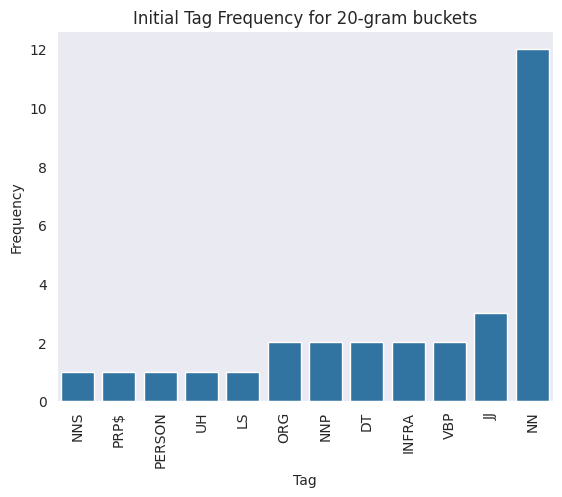

         Key  Value
7         LS      1
10        JJ      1
13    PERSON      1
12       GPE      1
11       PRP      1
8        NNS      1
9         UH      1
6   CARDINAL      2
5        POS      2
4         VB      2
3      INFRA      5
2        ORG      5
1        NNP      6
0         NN     19


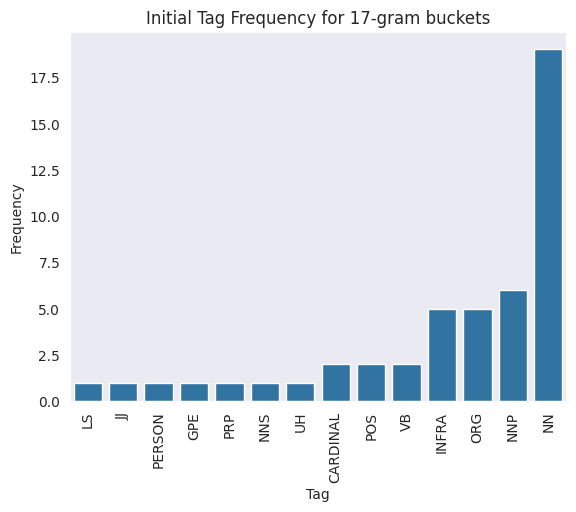

        Key  Value
6       VBP      1
7  CARDINAL      1
5       WEB      1
3       NNS      2
2       ORG      2
4        VB      2
1       NNP      5
0        NN      6


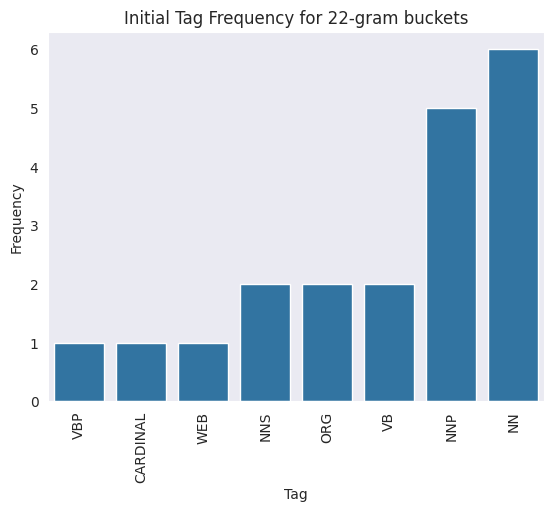

         Key  Value
19        UH      1
15        IN      2
16       TLD      2
14  CARDINAL      2
18        CC      2
17       PRP      2
13        DT      4
11       NNS      4
12       GPE      4
10       VBZ      5
9         XX      6
8         JJ      6
7     PERSON      7
5        WEB      8
6         VB      8
4        VBP     10
3        NNP     16
2        ORG     17
1      INFRA     19
0         NN     23


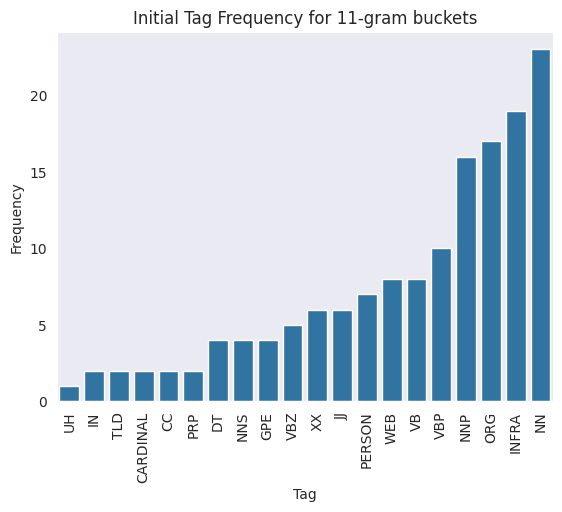

         Key  Value
15       GPE      1
14       NNS      1
17       VBG      1
16       POS      1
19        LS      1
18      PRP$      1
10  CARDINAL      2
11     PHASE      2
12       PRP      2
13        UH      2
9        WEB      3
8         VB      3
7         JJ      4
6         XX      5
5         NN     10
4      INFRA     11
3     PERSON     14
2        ORG     16
1        VBP     17
0        NNP     22


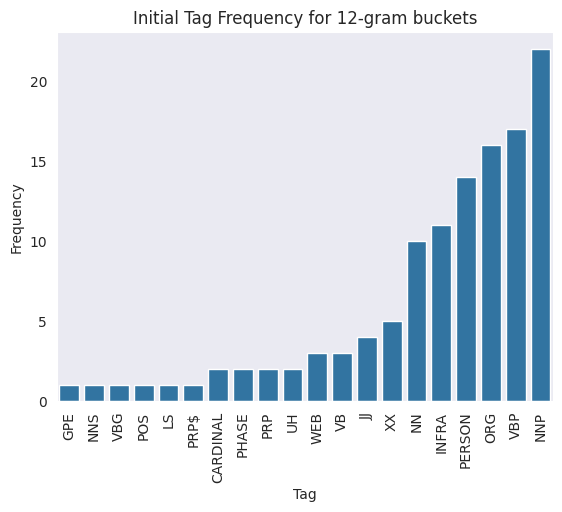

        Key  Value
3       POS      1
6     INFRA      1
5    PERSON      1
4       NNS      1
7        MD      1
2  CARDINAL      2
0       ORG      2
1        NN      2


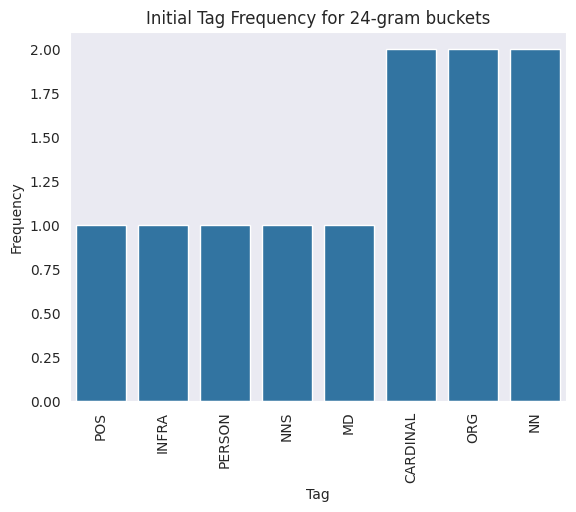

        Key  Value
5     INFRA      2
6        VB      2
4       NNS      2
3  CARDINAL      3
1       ORG      6
2       NNP      6
0        NN      8


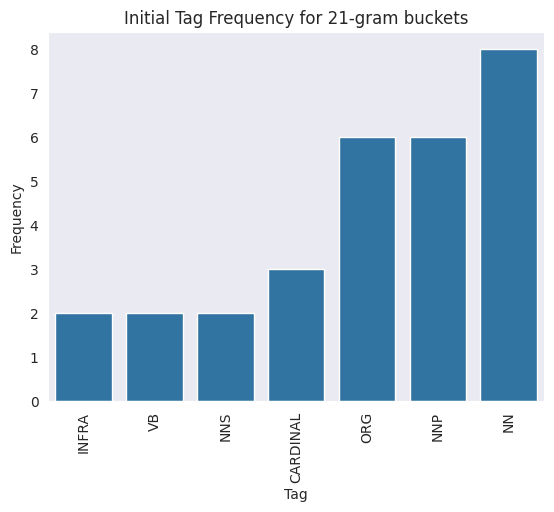

   Key  Value
0  ORG      1


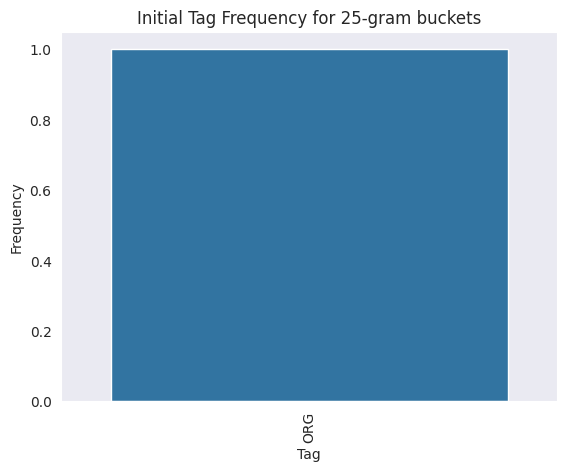

       Key  Value
3  ORDINAL      1
4      VBP      1
5       IN      1
2    INFRA      2
1      ORG      3
0       NN      5


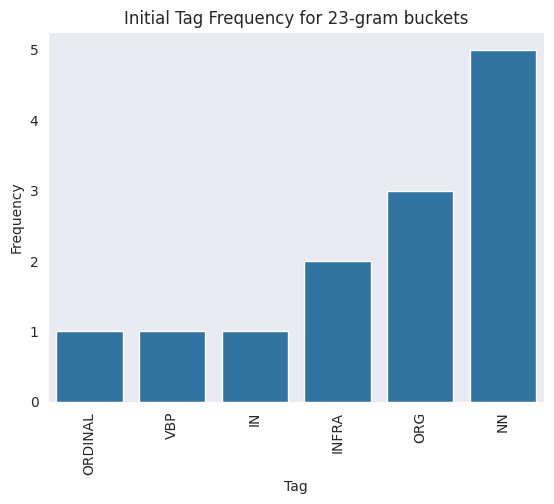

         Key  Value
6         UH      1
7        VBP      1
9     PERSON      1
8         JJ      1
10        CD      1
5        NNS      2
2        NNP      3
3      INFRA      3
4   CARDINAL      3
1        ORG      5
0         NN     17


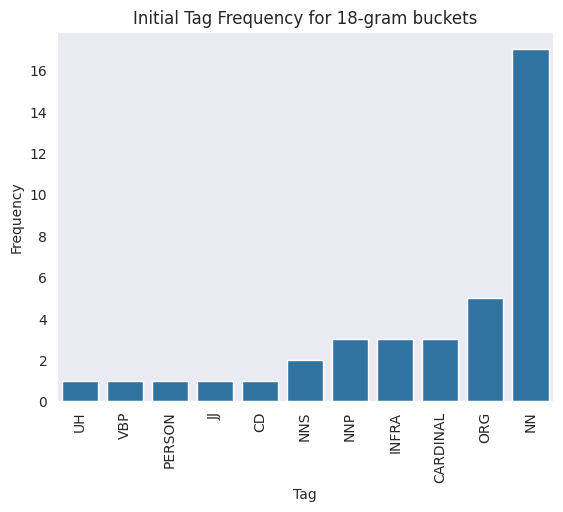

         Key  Value
15  CARDINAL      1
14        DT      1
13       VBD      1
12      DATE      1
11        JJ      1
10        FW      1
9         CD      1
8        PRP      1
7        ORG      2
6         XX      2
5      INFRA      3
4        WEB      3
3     PERSON      4
2        NNP      7
1        NNS      8
0         NN     11


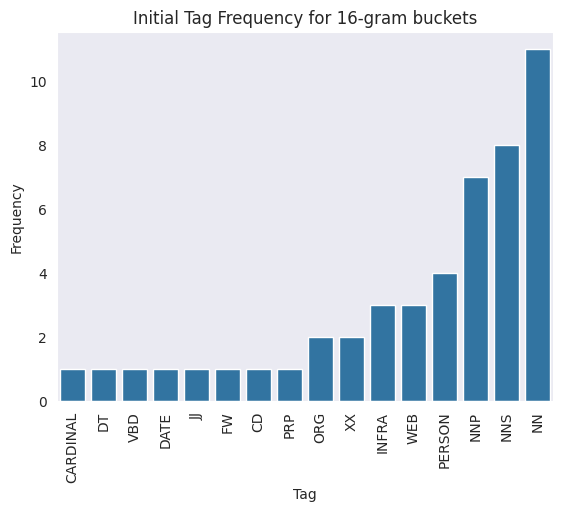

       Key  Value
12      RB      1
13      XX      1
15     VBP      1
14     VBD      1
10  PERSON      1
11     POS      1
16      DT      1
7       IN      2
9       UH      2
8      VBZ      2
6    INFRA      3
5       JJ      3
4       VB      4
3      NNS      4
2      NNP      8
1      ORG      9
0       NN     17


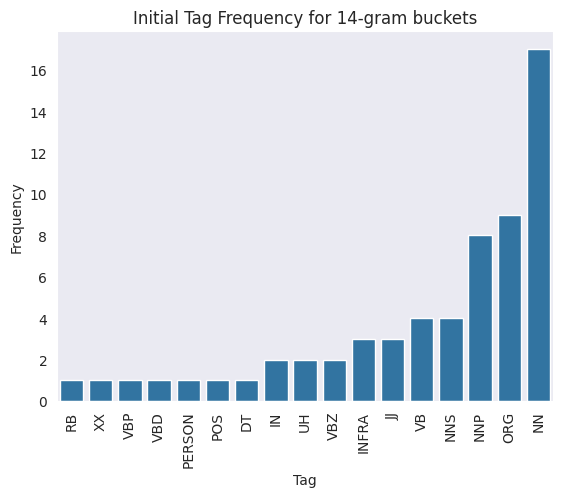

         Key  Value
12        FW      1
11       VBP      1
10       VBN      1
13       TLD      1
9       DATE      1
6         VB      2
5        NNP      2
7   CARDINAL      2
8         JJ      2
3        NNS      3
4     PERSON      3
1        ORG      6
2      INFRA      6
0         NN     11


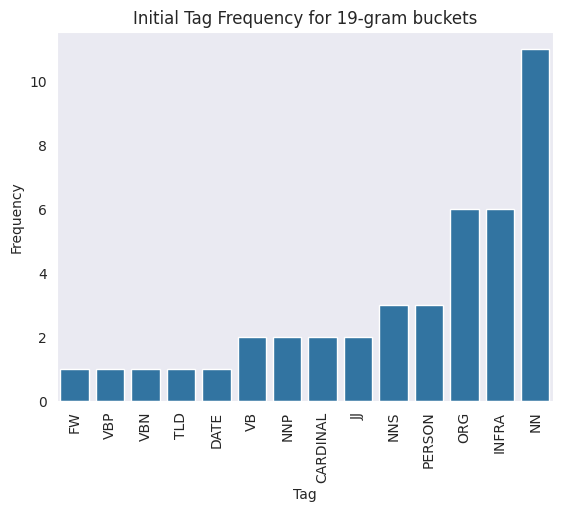

         Key  Value
15        LS      1
14    PERSON      1
13       VBD      1
12        IN      1
11        VB      1
10        XX      1
9        VBP      1
8        NNS      1
7         UH      2
6        POS      2
5         JJ      3
3        ORG      4
4      INFRA      4
2   CARDINAL      4
1        NNP      9
0         NN     20


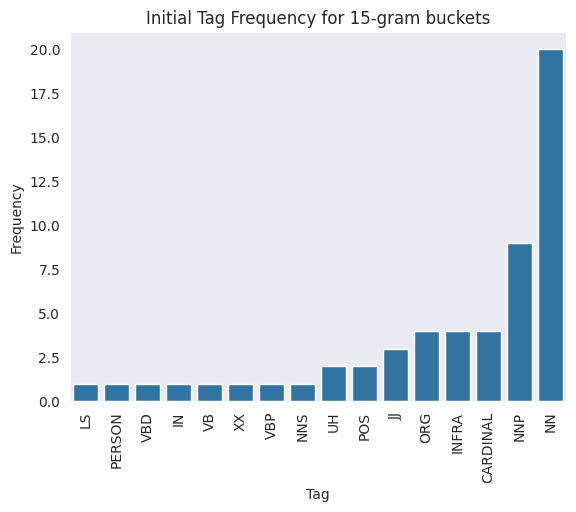

        Key  Value
0  CARDINAL      1
1        NN      1


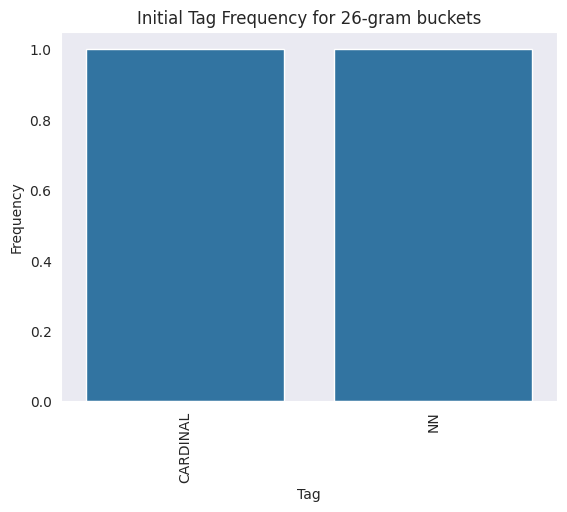

   Key  Value
0  NNP      1


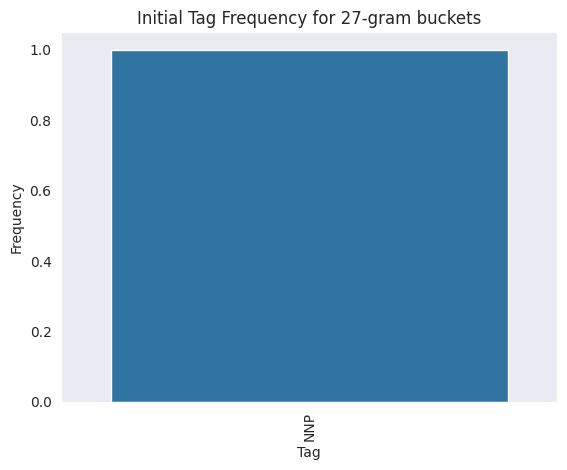

In [ ]:
#
# Let's figure out initial state distributions for each ngram
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

initial_states_map = {}  # map[ngram, map[initial_state, count]]

with open('tagged_buckets.json', 'r') as f:
    tagged_buckets

for bucket in tagged_buckets:
    ngram = len(bucket)
    tag = bucket[0][1]
    states = initial_states_map.get(ngram, {})
    count = states.get(tag, 0)
    count += 1
    states[tag] = count
    initial_states_map[ngram] = states

print(initial_states_map)
    

for ngram, tags in initial_states_map.items():

    #
    # To prevent the long-tail from clogging up our view, use the top tags only
    #
    top_tags = sorted(tags.items(), key=lambda item: item[1], reverse=True)[:20]
    # filtered_n_grams = {key: value for key, value in initial_states_map.items() if value >= 50}

    # Convert dictionary to DataFrame
    df = pd.DataFrame(top_tags, columns=["Key", "Value"])

    # Sort the DataFrame by "Key" to match ascending key order
    df = df.sort_values(by="Value", ascending=False)
    print(df)
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply the scaler to normalize all values in the DataFrame
    # df_normalized = pd.DataFrame(scaler.fit_transform(df), columns='Value')

    # Plot the frequency with Seaborn
    sns.set_style("dark")
    sns.barplot(x="Key", y="Value", data=df)
    plt.title(f"Initial Tag Frequency for {ngram}-gram buckets")
    plt.xlabel("Tag")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.show()